# **Imports**

In [2]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit

import matplotlib.pyplot as plt

import ott
from ott.geometry import pointcloud
from ott.neural.networks import potentials
from ott.problems.linear import potentials

import plotly.graph_objects as go
import time
import math

from sklearn.metrics import mean_squared_error

from tqdm import tqdm

import torchvision.datasets as datasets
import torchvision
import torch

from functools import partial

In this notebook, we will test the entropic map introduced by Pooladian and Niles-Weed in the paper [*Entropic estimation of optimal transport maps*](https://arxiv.org/pdf/2109.12004.pdf).


# **The entropic estimator**

$\newcommand{\cali}{\mathcal}$
$\newcommand{\inc}{\subset}$
$\newcommand{\R}{\mathbb{R}}$
$\newcommand{\N}{\mathbb{N}}$   

**Notation & Vocabulary :**

For this problem, we place ourselves in the euclidian space $(\R^d,\|.\|)$ and denote by $\cali{P}(\R^d)$ the set of Borel probability measures on $\R^d$. Given two probabilities measures $P$ and $Q$ on $\Omega ⊆ \R^d $, we define the set of admissible maps $\cali{T}(P, Q) $ as $\cali{T}(P, Q) := \left\{ T : \Omega \rightarrow \Omega \, \middle| \, \quad T_{\#}P = P \circ T^{-1} = Q \right\}$.

## Background on optimal transport theory

The goal of optimal transport is to find a map between two probability distributions - here $P$ and $Q$ - that
minimizes the squared Euclidean transportation cost. To do so, many problems have been defined.

**The Monge problem :**

The Monge optimal transport problem minimizes the transport cost:
$$
  \min_{T \in \cali{T}(P,Q)}  \int_{\R^d} \frac{1}{2}\|x-T(x)\|^2 \text{d}P(x)
$$

However, a solution to this problem, the optimal map also called Monge map,  might not exist if $P$ does not have a density. This problem can be improved by passing to a convex relaxation with the Kantorovich problem.

**The Kantorovich problem :**
The Kantorovich problem is a relaxed version of the Monge problem which leads to the definition of the 2-Wasserstein distance :
$$
   \frac{1}{2} W_2^2(P,Q) = \min_{\pi \in \Pi(P, Q)} \int_{\R^d\times\R^d} \frac{1}{2}\|x-y\|_2^2 \text{d}\pi(x,y)
$$
where

$$
\Pi(P, Q) := {\pi \in P(\Omega × \Omega) | \pi(A × \Omega) = P(A), \pi(\Omega × A) = Q(A)}
$$
is the set op couplings between $P$ and $Q$.
This problem will always admits a minimizer whenever $P$ and $Q$ have a finite second moments. This solution is called an *optimal plan* denoted $\pi_0$.
A dual formulation also exists for this problem :

$$
\frac{1}{2} W_2^2(P,Q) = \sup_{(f,g) \in \Phi} \left( \int f \, dP + \int g \, dQ \right)
$$
where :

$$
\Phi = \left\{ (f, g) \in L^1(P) \times L^1(Q) \, \middle| \, f(x) + g(y) \leq \frac{1}{2} \|x - y\|^2_2 \, \text{for all } x, y \in \Omega \right\}
$$

The solution of this supremum is a pair $(f_0,g_0)\in \Phi$, called *optimal potentials*.

## Entropic optimal transport
This method of transport is defined by adding  an entropic regularization term to the Kantorovich problem and a regularization parameter $ϵ$ (Peyré and Cuturi, 2019). The entropically regularized problem is as following:

$$
S_\varepsilon(P, Q) := \inf_{\pi \in \Pi(P,Q)} \left( \iint \frac{1}{2} \|x - y\|^2_2 \, d\pi(x, y) + \varepsilon D_{KL}(\pi \| P \otimes Q) \right)
$$

where $\Pi(P,Q)$ denotes the set of couplings between $P$ and $Q$ and $D_{KL}$ denotes the Kullblack-Liebler divergence between two measures.
The solution of this equation is $\pi_ϵ$, the *optimal entropic plan*.
This problem also admits a dual solution, $(f_ϵ, g_\epsilon)$ which we call the optimal entropic potentials. Those two functions will satisfy :  
$$
\int e^{\frac{1}{\varepsilon} \left( f_\varepsilon(x) + g_\varepsilon(y) - \frac{1}{2} \|x - y\|^2_2 \right)} \, dP(x) = 1 \quad \forall y \in \mathbb{R}^d
$$
$$
\int e^{\frac{1}{\varepsilon} \left( f_\varepsilon(x) + g_\varepsilon(y) - \frac{1}{2} \|x - y\|^2_2 \right)} \, dQ(y) = 1 \quad \forall x \in \mathbb{R}^d
$$

This approach leads to a problem that can be adressed by Sinkhorn’s algorithm, which exhibits a time complexity that grows quadratically in the number of samples. Furthermore, Sinkhorn’s algorithm is well suited for parallel implementation on GPUs, making it very attractive for large-scale problems.

## The entropic map

Given the optimal entropic plan $π_ϵ$ between $P$ and $Q$, the authors define its barycentric projection :
$$
T_\varepsilon(x) := \int y \, d\pi_\varepsilon^x(y) = \mathbb{E}_{\pi_\varepsilon}[Y | X = x].
$$

As the previous duality relation implies a definition of $d\pi_\varepsilon^x(y)$, the authors finally obtain the *entropic map* between $P$ and $Q$ :
$$
T_\varepsilon(x) :=
\frac{\int y e^{\frac{1}{\varepsilon} \left( g_\varepsilon(y) - \frac{1}{2} \|x - y\|^2_2 \right)} \, dQ(y)}{\int e^{\frac{1}{\varepsilon} \left( g_\varepsilon(y) - \frac{1}{2} \|x - y\|^2_2 \right)} \, dQ(y)}
$$

In many applications, we do not have direct access to the complete probability measures $P$ and $Q$, but rather independent samples drawn from them. These samples are denoted as  $(X_1, ..., X_n) \sim P$ and  $(Y_1, ..., Y_n) \sim Q$.
When an optimal map $T_0 \in \cali{T}(P, Q)$ minimizing the Monge problem exists, a natural question arises : can we estimate $T_0$ based on these samples? Writing $P_n = \frac{1}{n} \sum_{i=1}^{n} \delta_{X_i}$ and $Q_n = \frac{1}{n} \sum_{i=1}^{n} \delta_{Y_i}$ for the empirical distributions to the samples and they proposed the following *entropic map* between $P_n$ and $Q_n$ :
$$
T_{\varepsilon,(n,n)}(x) = \frac{ \frac{1}{n} \sum_{i=1}^{n} Y_i e^{\frac{1}{\varepsilon} \left( g_{\varepsilon,(n,n)}(Y_i) - \frac{1}{2} \|x - Y_i\|^2_2 \right)} }{ \frac{1}{n} \sum_{i=1}^{n} e^{\frac{1}{\varepsilon} \left( g_{\varepsilon,(n,n)}(Y_i) - \frac{1}{2} \|x - Y_i\|^2_2 \right)} }
$$

The entropic potentials can be obtained as part of the output of Sinkhorn's algorithm, which offers an evaluation of the entropic map in linear time. As in standard non parametric estimation, the optimal choice of $\epsilon$ will be
dictated by the smoothness of the target function.

They assume that, under suitable technical assumptions on $P$ and $Q$, this entropic map $\hat{T}= T_{ϵ,(n,n)}$ with regularization parameter $\epsilon = n^{-\frac{1}{d' + \bar{\alpha} + 1}}$ enjoys the rate :

$$
E_k \| \hat{T} - T_0 \|_2^2 \, \text{L}_2(P) \lesssim (1 + I_0(P, Q))n^{-\frac{\bar{\alpha}+1}{2(d'+\bar{\alpha}+1)}
 \log(n)}
$$

for $d' = 2\left\lceil \frac{d}{2} \right\rceil$ and $\bar{\alpha} = \alpha \wedge 3
$.

As the dimension $d$ approaches infinity and the parameter $\alpha$ approaches 1, the estimator $\hat{T}$ formally converges at a rate of $n^{-(1+o(1))/d}$. However, Hütter and Rigollet (2021) showed that the optimal convergence rate, up to logarithmic factors, is $n^{-2/d}$, considered minimax optimal in this context, meaning it is the best possible rate that any estimator can achieve in this setting. While this Theorem achieves a rate of $n^{-\frac{1}{d}}$, falling short of the minimax rate, their numerical experiments in demonstrate that $\hat{T}$ is competitive with minimax-optimal estimators in practice.
Finally, the authors showed with the first-sample and the second-sample settings that the entropic map between $P_n$ and $Q_n$ is close to $T_0$ in expectation.

We will now test its statistical and computational performances on toy data.

# **The tools from OTT-JAX**

## Auxiliary functions

We first define functions to create toy data. We will first consider here *iid* samples drawn from a centered normal law. 

In [263]:
def generate_multivariate_normal_points(key, N, dimension, var):
    mean = jnp.zeros(dimension)
    cov = jnp.eye(dimension) * var
    return jax.random.multivariate_normal(key, mean, cov, shape=(N,))

We also define a funtion to visualize two distributions in 3D.

In [832]:
def plot_3D_from_two_sources(points_jax1, points_jax2, name_1, name_2):

    points1 = np.array(points_jax1)
    points2 = np.array(points_jax2)

    # Plotting
    fig = go.Figure()

    # Add the second set of points
    fig.add_trace(go.Scatter3d(
        x=points2[:, 0],
        y=points2[:, 1],
        z=points2[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',
            opacity=0.5
        ),
        name=name_2  
    ))

    # Add the first set of points
    fig.add_trace(go.Scatter3d(
        x=points1[:, 0],
        y=points1[:, 1],
        z=points1[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='blue', 
            opacity=0.5,
        ),
        name=name_1  
    ))

    fig.update_layout(
        title="3D Scatter Plot of Two Sets of Points",
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        ),
        autosize=False,
        width=1200,
        height=500,
        margin=dict(l=65, r=50, b=65, t=90)
    )

    fig.show()

To visualize the transport of a sample on its first two dimensions :

In [265]:
def plot_transport_first_2_dimensions(new_distribution, target_points, transported_samples): 
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 6)) 

    axs[0].scatter(target_points[:, 0], target_points[:, 1], label='Target', alpha=0.6)
    axs[0].scatter(new_distribution[:, 0], new_distribution[:, 1], label='Source', alpha=0.6)
    axs[0].set_title('Source vs Target Distribution')
    axs[0].legend()
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')

    axs[1].scatter(target_points[:, 0], target_points[:, 1], label='Target', alpha=0.6)
    axs[1].scatter(transported_samples[:, 0], transported_samples[:, 1], label='Transported Samples', alpha=0.6)
    axs[1].set_title('Target vs Transported Distribution')
    axs[1].legend()
    axs[1].set_xlabel('X Coordinate')
    axs[1].set_ylabel('Y Coordinate')

    plt.tight_layout()
    plt.show()

We will take as the true optimal transport map the function : 

In [894]:
def exp(points):
    return 3*points**2 * jnp.sign(points) * jnp.cos(points)**2 

## Illustration in 3D

We define the main hyperparameters :

In [900]:
number_of_samples = 1000
dimension = 3
variance = 1
key = jax.random.PRNGKey(0)

And the source and target distributions :

In [901]:
source_points = generate_multivariate_normal_points(key, number_of_samples, dimension, variance)
target_points = exp(source_points)

In [902]:
plot_3D_from_two_sources(source_points, target_points, 'source', 'target')

We define the geometry between the two distributions as well as the Sinkhorn solver to get access to the two potentials $f$ and $g$.

We also define here the $\epsilon$ regularization parameter, which we choose to be equal to $1$ for now, and we will investigate it's effect later

In [903]:
geom = ott.geometry.pointcloud.PointCloud(source_points, target_points, epsilon=1)                   
problem = ott.problems.linear.linear_problem.LinearProblem(geom)  

In [904]:
solver = ott.solvers.linear.sinkhorn.Sinkhorn()   

We launch the Sinkhorn algorithm on our problem and gather the two potentials, which alows us to define the dual potential functions from finite samples : 

$$
g^{(k)}(y) = -\epsilon \log \left( \frac{1}{n} \sum_{i=1}^n \exp\left(\frac{1}{\epsilon} \left(f^{(k)}(X_i) - \frac{1}{2} \|X_i - y\|^2\right)\right)\right)
$$

$$
f^{(k+1)}(y) = -\epsilon \log \left( \frac{1}{n} \sum_{j=1}^n \exp\left(\frac{1}{\epsilon} \left(g^{(k)}(Y_j) - \frac{1}{2} \|x - Y_j\|^2\right)\right)\right)
$$

In [905]:
out = solver(problem)                                     

f = out.f                                                      
g = out.g

entropic_potentials = potentials.EntropicPotentials(f, g, problem)

Next we can access the map given by the entropic estimator :

$$
T^{(k)}(x) = \frac{\sum_{i=1}^n Y_i \exp\left(\frac{1}{\epsilon} \left(g^{(k)}(Y_i) - \frac{1}{2} \|x - Y_i\|^2\right)\right)}{\sum_{i=1}^n \exp\left(\frac{1}{\epsilon} \left(g^{(k)}(Y_i) - \frac{1}{2} \|x - Y_i\|^2\right)\right)}
$$

In [906]:
map = entropic_potentials.transport

We now generate visualize the transported source distribution compared to the target distribution. 

In [907]:
transported_samples = map(source_points)

In [908]:
plot_3D_from_two_sources(transported_samples, target_points, 'transported samples', 'target points')

And on the first two dimensions : 

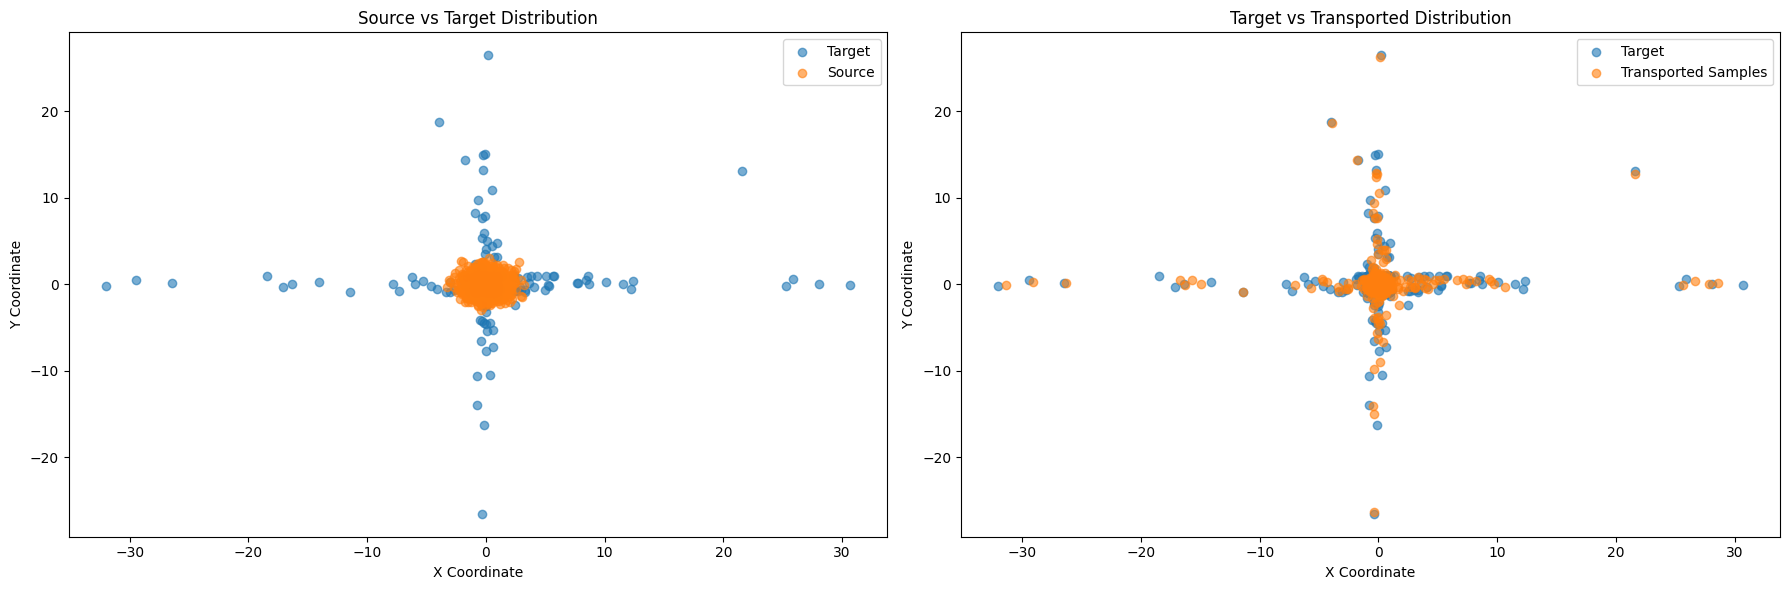

In [909]:
plot_transport_first_2_dimensions(source_points, target_points, transported_samples)

# **Statistical performance**

We want to try to get some measures of the performace of the entropic map depending of the choice of $\epsilon$, the dimension and the number of samples in the distributions. We first define the function that gives the transport map from the entropic estimator, and some useful functions for plotting :

## Functions

In [26]:
def entropic_map(x, y, epsilon):
    """Generate the entropic map from x to y with a given epsilon."""
    geom = pointcloud.PointCloud(x, y, epsilon = epsilon)
    problem = ott.problems.linear.linear_problem.LinearProblem(geom)  
    output = solver(problem)
    entropic_potentials = potentials.EntropicPotentials(output.f, output.g, problem)
    return entropic_potentials.transport

In [702]:
def plot_analysis_from_epsilon(dic_mse, dic_runtime, dimensions, epsilon_values, optimal_epsilon):
    """Plot the MSE and runtime as a function of epsilon for different dimensions."""

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(dimensions))) 

    # Plot MSE as a function of the number of samples
    for idx, dim in enumerate(dimensions):
        color = colors[idx]
        ax1.plot(epsilon_values, dic_mse[dim].values(), color=color, marker='o', label=f'Dim {dim}')
        ax1.axvline(x=optimal_epsilon[dim], color=color, linestyle='--', linewidth=2, label=f'Optimal epsilon for Dim {dim}')

    ax1.set_title('MSE vs. epsilon')
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('MSE')
    ax1.set_xscale('log', base=10)
    ax1.set_yscale('log', base=10)
    ax1.legend()

    # Plot Runtime as a function of the number of samples
    for idx, dim in enumerate(dimensions):
        color = colors[idx]
        ax2.plot(epsilon_values, dic_runtime[dim].values(), color=color, marker='o', label=f'Dim {dim}')
        ax2.axvline(x=optimal_epsilon[dim], color=color, linestyle='--', linewidth=2, label=f'Optimal epsilon for Dim {dim}')

    ax2.set_title('Runtime vs. epsilon')
    ax2.set_xlabel('epsilon')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_xscale('log', base=10)
    ax2.set_yscale('log', base=10)
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [940]:
def plot_analysis_from_samples(dic_mse, dic_runtime, dimensions, number_of_samples):
    """Plot the MSE and runtime as a function of the number of samples for different dimensions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot MSE as a function of the number of samples
    for dim in dimensions:
        line1, = ax1.plot(number_of_samples, dic_mse['adjusted_epsilon'][dim].values(), marker='o', label=f'adjusted epsilon Dim {dim}')
        ax1.plot(number_of_samples, dic_mse['default_epsilon'][dim].values(), marker='o', linestyle='dashed', color=line1.get_color(), label=f'default epsilon Dim {dim}')

    ax1.set_title('MSE vs. Number of Samples')
    ax1.set_xlabel('Number of Samples')
    ax1.set_ylabel('MSE')
    ax1.set_xscale('log', base=10)
    ax1.set_yscale('log', base=10)
    ax1.legend()

    # Plot Runtime as a function of the number of samples
    for dim in dimensions:
        line2, = ax2.plot(number_of_samples, dic_runtime['adjusted_epsilon'][dim].values(), marker='o', label=f'adjusted_epsilon Dim {dim}')
        ax2.plot(number_of_samples, dic_runtime['default_epsilon'][dim].values(), marker='o', linestyle='dashed', color=line2.get_color(), label=f'default epsilon Dim {dim}')

    ax2.set_title('Runtime vs. Number of Samples')
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Runtime (seconds)')
    ax2.set_xscale('log', base=10)
    ax2.set_yscale('log', base=10)
    ax2.legend()

    plt.tight_layout()
    plt.show()

## Analysis

We are going to repeat the same experiment as we did in 3D, but with increased dimensions and a number of times `n_trials`. First we study the effect of $\epsilon$ and we look at the average mean square error of our entropic maps, and the average running time of the implementation of the estimator. Here, we fix a number of samples of $1000$.

In [938]:
n_trials = 5
dimensions = [2, 3, 5, 10]
variance = 1
key = jax.random.PRNGKey(0)
number_of_samples = 1000

We will take a look at theses values for $\epsilon$ :

In [936]:
epsilon_values = [0.1, 0.5, 1, 5, 10]

We try to justify the choice of epsilon presented in the article :

$$
\epsilon \asymp n^{-\frac{1}{d' + \bar\alpha + 1}}
$$

with $d' = 2 \left\lceil \frac{d}{2} \right\rceil$ and $\bar{\alpha} = \min (\alpha, 3)$.

As recommended, we will implement a function that computes the value of $\epsilon$ recommended by Theorem 3. We will also plot the value given by the formula and compare it to the curves of MSE and running time.

In [31]:
def give_epsilon(dimension, number_of_samples, alpha):
    d_prime = 2 * math.ceil(dimension/2)
    alpha_bar = min(alpha, 3)
    exponent = -1 / (d_prime+alpha_bar+1)
    return number_of_samples ** exponent

As $\exp$ is infinitely continuous, we will always take $\alpha = 3$.

**Loop :**

In [930]:
average_mses = {}
average_runtimes = {}
optimal_epsilons = {}

for dim in tqdm(dimensions):

    average_mses[dim] = {}
    average_runtimes[dim] = {}
    optimal_epsilons[dim] = give_epsilon(dim, number_of_samples, 3)

    for epsilon in epsilon_values:

        list_of_mse = []
        list_of_runtimes = []

        for trial in range(n_trials):

            key, subkey = jax.random.split(key)
            source_points = generate_multivariate_normal_points(key, number_of_samples, dim, variance)
            target_points = exp(source_points)

            start_time = time.perf_counter()

            map = entropic_map(source_points, target_points, epsilon=epsilon)

            end_time = time.perf_counter()
            duration = end_time - start_time

            transported_samples = map(source_points)

            mse = mean_squared_error(transported_samples, target_points)

            list_of_mse.append(mse)
            list_of_runtimes.append(duration)

        average_mses[dim][epsilon] = np.mean(list_of_mse)
        average_runtimes[dim][epsilon] = np.mean(list_of_runtimes)

100%|██████████| 4/4 [00:27<00:00,  6.88s/it]


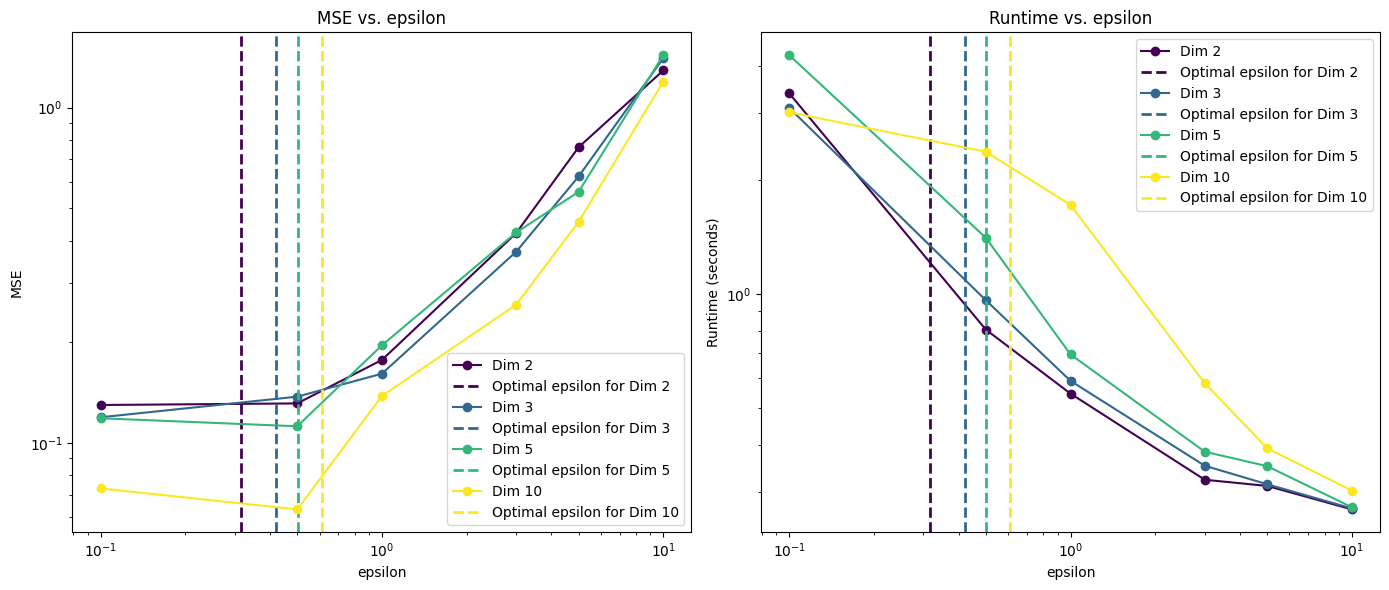

In [931]:
plot_analysis_from_epsilon(average_mses, average_runtimes, dimensions, epsilon_values, optimal_epsilons)

By analyzing these curves, we see that the exact values given by Theorem 3 are indeed retuning the smallest errors. However they come with a higher computational cost, especially as the dimension increases. 

Now more specifically, we look at the effect of the number of samples and the dimension on the MSE and the running time, and we also compare the performance of the estimator with the default value of $\epsilon$ (equal to `mean_cost_matrix`$/20$) or with the value we defined just above and suggested by the article.

**Hyperparameters :**

In [946]:
number_of_samples = [50, 100, 500, 1000]
dimensions = [5, 10, 20]
key = jax.random.PRNGKey(0)

**Loop :**

In [947]:
average_mses = {'adjusted_epsilon':{}, 'default_epsilon':{}}
average_runtimes = {'adjusted_epsilon':{}, 'default_epsilon':{}}

for dim in tqdm(dimensions):

    for method in average_mses.keys():

        average_mses[method][dim] = {}
        average_runtimes[method][dim] = {}

    for n_sample in number_of_samples:

        mses = {}
        runtimes = {}
        epsilon = give_epsilon(dim, n_sample, 3)

        for method in average_mses.keys():
            
            mses[method] = []
            runtimes[method] = []
    
        for trial in range(n_trials):
                
            key, subkey = jax.random.split(key)
            source_points = generate_multivariate_normal_points(key, n_sample, dim, variance)
            target_points = exp(source_points)

            # For adjusted_epsilon 
            start_time = time.perf_counter()
            
            map = entropic_map(source_points, target_points, epsilon)
                    
            end_time = time.perf_counter()
            duration = end_time - start_time

            transported_samples = map(source_points)

            mse = mean_squared_error(transported_samples, target_points)

            mses['adjusted_epsilon'].append(mse)
            runtimes['adjusted_epsilon'].append(duration)

            # For default_epsilon
            start_time = time.perf_counter()
            
            map = entropic_map(source_points, target_points, epsilon=None) 
            
            end_time = time.perf_counter()

            transported_samples = map(source_points)

            mse = mean_squared_error(transported_samples, target_points)

            mses['default_epsilon'].append(mse)
            runtimes['default_epsilon'].append(duration)
        
        for method in average_mses.keys():
            average_mses[method][dim][n_sample] = np.mean(mses[method])
            average_runtimes[method][dim][n_sample] = np.mean(runtimes[method])

100%|██████████| 3/3 [01:08<00:00, 22.80s/it]


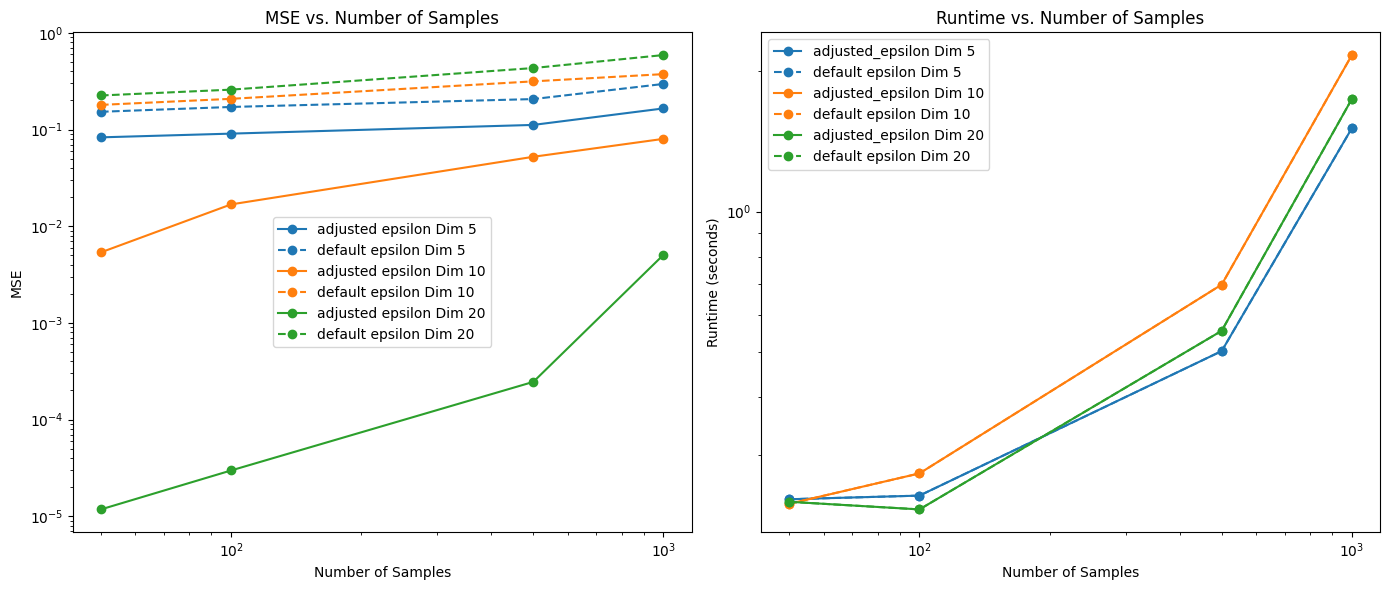

In [948]:
plot_analysis_from_samples(average_mses, average_runtimes, dimensions, number_of_samples)

These graphs illustrate the relevance of setting $\epsilon \asymp n^{-\frac{1}{d' + \bar\alpha + 1}}$, especially as the dimension and the number of samples increase, and keeping the computation cost roughly near the second for a thousand samples. Moreover, as it is highlighted in the article, the convergence guarantees of the entropic estimator and it's accuracy in high dimensions can be coupled with a parallel implementation of the Sinkhorn algorithm for a more efficient computation of the transport map.

# **Illustration on the MNIST**

After showing the efficiency of the estimator on synthetic data, we now use it on real data. Since the estimator works on $R^d$ with a $d$ that can be quite large we chose to work on the MNIST dataset as it contains images in dimension 28x28 (which corresponds to $R^{784}$). The MNIST dataset contains images of handly written numbers from $0$ to $9$. 

## Creating the dataset

In [9]:
# Load MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True)
mnist_data = mnist_trainset.data
mnist_labels = mnist_trainset.targets

100%|██████████| 9912422/9912422 [00:00<00:00, 67145537.78it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69618214.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 47698105.40it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 42054147.39it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Our idea to illustrate the performance of the estimator is to create subsets of the MNIST dataset containing only images representing the number $1$ and $2$, and to create a transport map between the two subsets using the estimator. Here you can see the code used to create the subsets :

In [11]:
# We keep first the images representing '1'
filter1 = mnist_labels == 1
mnist_data_1 = mnist_data[filter1]
mnist_labels_1 = mnist_labels[filter1]

# Then the images representing '2'
filter2 = mnist_labels == 2
mnist_data_2 = mnist_data[filter2]
mnist_labels_2 = mnist_labels[filter2]

# Print to check the shapes (the training MNIST dataset contains 6742 '1' and 5958 '2')
print(mnist_data_1.shape, mnist_labels_1.shape)
print(mnist_data_2.shape, mnist_labels_2.shape)

torch.Size([6742, 28, 28]) torch.Size([6742])
torch.Size([5958, 28, 28]) torch.Size([5958])


We then transform the 28x28 vectors in $784$ vectors so we can use the estimator on them :

In [15]:
# Reshapes the 28x28 vectors into 784 vectors 

transform = torchvision.transforms.Resize((28,28))
mnist_data_resize_1 = np.array(transform(mnist_data_1))
mnist_data_final_1 = jnp.array([elt.reshape(28*28).astype(float)/255.0 for elt in mnist_data_resize_1])
print(mnist_data_final_1.shape) # we check the shape

transform = torchvision.transforms.Resize((28,28))
mnist_data_resize_2 = np.array(transform(mnist_data_2))
mnist_data_final_2 = jnp.array([elt.reshape(28*28).astype(float)/255.0 for elt in mnist_data_resize_2])
print(mnist_data_final_2.shape) # we check the shape

(6742, 784)
(5958, 784)


We first create a sampler, which allows to sample from the dataset like a dataloader :

In [22]:
class sampler_from_data:
    def __init__(self, x ):
        self.x = x
        self.setup()

    def setup(self):
        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            points = jax.random.choice(key, self.x, (num_samples,))      
            return points

        # define samples generator
        self.generate_samples = generate_samples

We then create a function to represent samples from our dataset, it allows us to see how '1' and '2' can look :

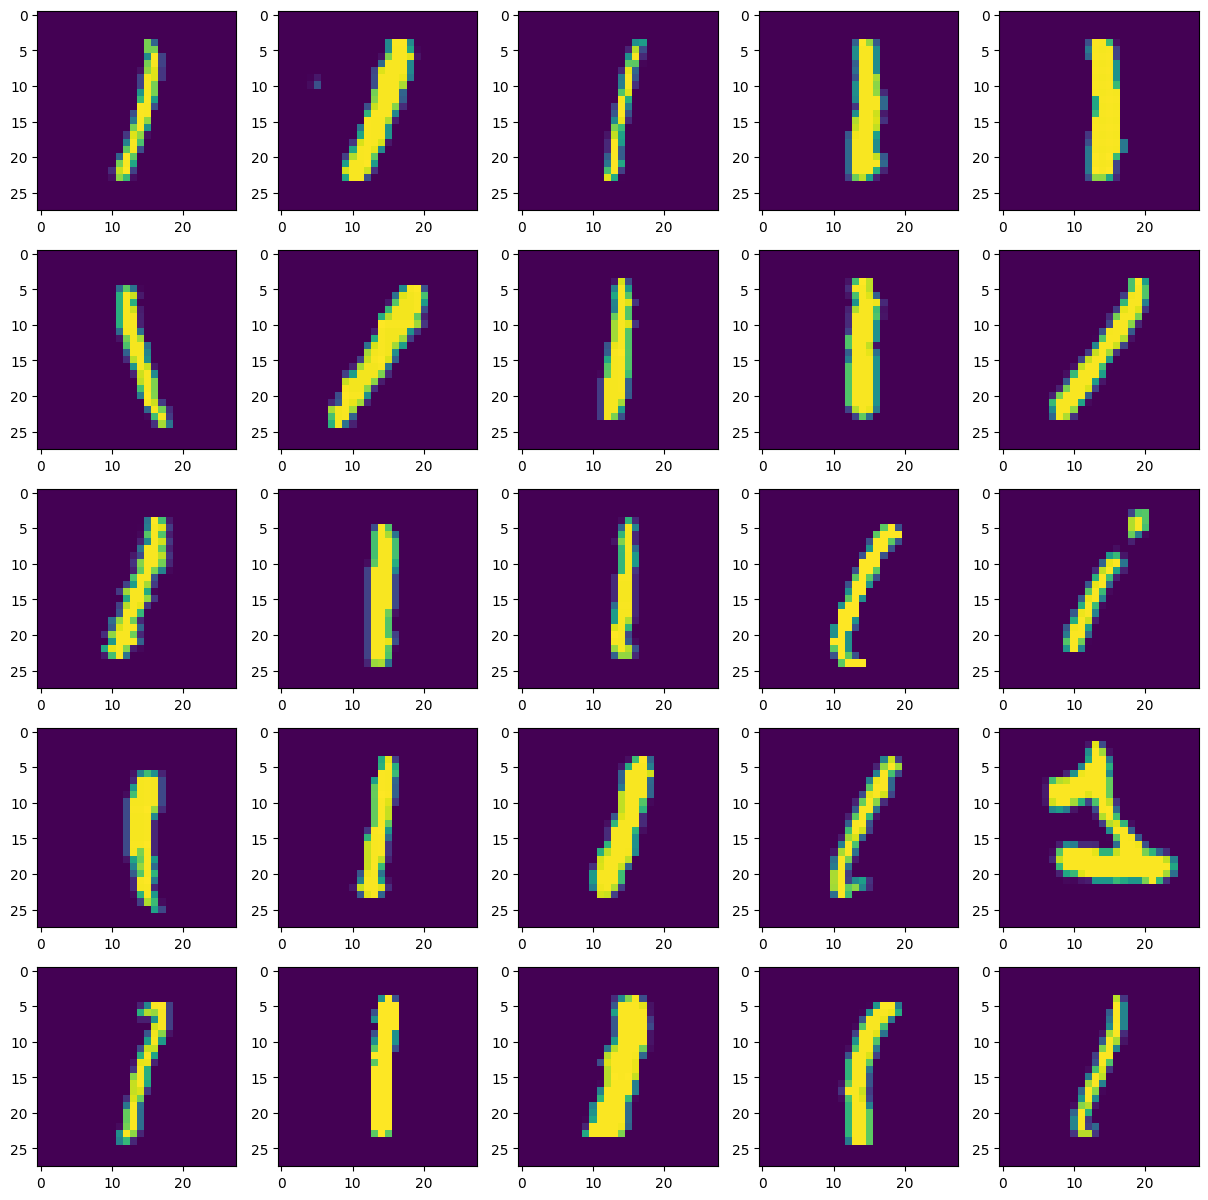

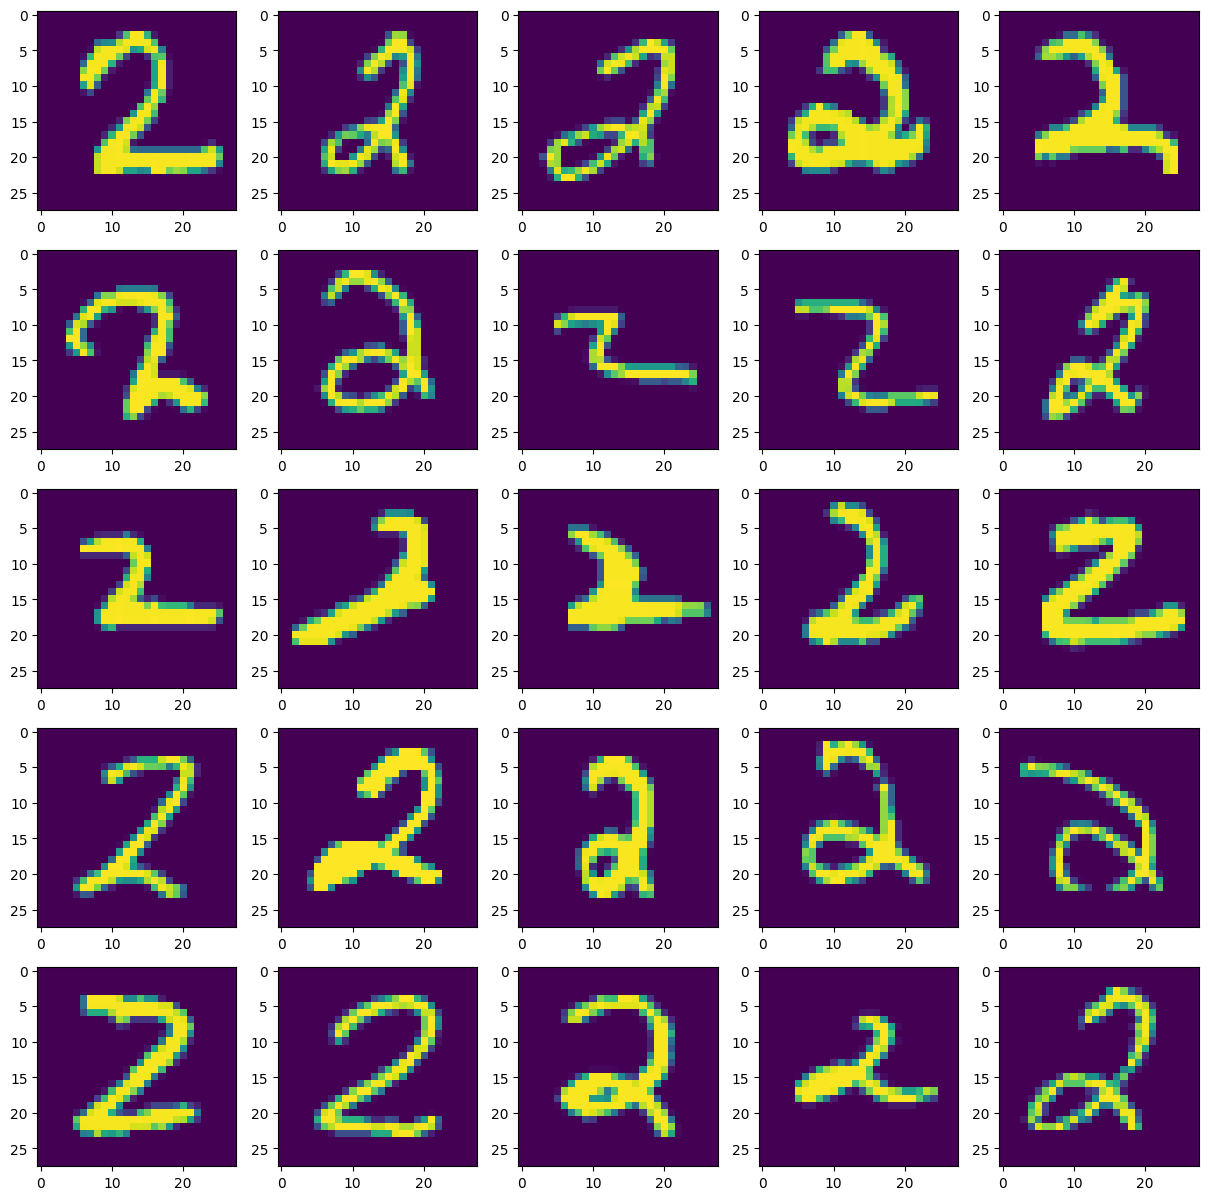

In [24]:
# Generates a random key to make it reproductible
rng = jax.random.PRNGKey(0)

# Creates a function to represent the datasets

def plot_dataset(sample, offset = 0):
    fig = plt.figure(figsize=(15, 15))
    columns = 5
    rows = 5
    for i in range(1, columns*rows +1):
        img = sample[offset+i].reshape(28,28)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

# Samples from MNIST
sampler_source_train_1 = sampler_from_data(mnist_data_final_1)  # '1'
sampler_source_train_2 = sampler_from_data(mnist_data_final_2)  # '2'

# Sample 50 images
source_samples_1 = sampler_source_train_1.generate_samples(rng, 50)  
source_samples_2 = sampler_source_train_2.generate_samples(rng, 50)  

# Plot
plot_dataset(source_samples_1)
plot_dataset(source_samples_2)

## Using the entropic estimator

We fist compute the $\epsilon$ given by the settings of the experiment and our formula :

In [29]:
n_samples, dimension = mnist_data_final_1.shape 

In [32]:
epsilon = give_epsilon(dimension, n_samples, 3)

Now, we can use the same map function as in the previous part, computing the map given by the entropic estimator :

In [25]:
solver = ott.solvers.linear.sinkhorn.Sinkhorn()     

In [33]:
map = entropic_map(mnist_data_final_1, mnist_data_final_2, epsilon)

Now, to test the efficiency of the map defined by the estimator, we need to apply it on the test data from the MNIST dataset. We start by creating a subset of the test dataset containing only '1' :

In [35]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True)
mnist_data_test = mnist_testset.data
mnist_labels_test = mnist_testset.targets

filter3 = mnist_labels_test == 1
mnist_data_test_1 = mnist_data_test[filter3]
mnist_labels_test_1 = mnist_labels_test[filter3]

print(mnist_data_test_1.shape, mnist_labels_test_1.shape)

torch.Size([1135, 28, 28]) torch.Size([1135])


Then we reshape it as we did earlier :

In [36]:
transform = torchvision.transforms.Resize((28,28))
mnist_data_resize_test = np.array(transform(mnist_data_test_1))
mnist_data_final_test_1 = jnp.array([elt.reshape(28*28).astype(float)/255.0 for elt in mnist_data_resize_test])
print(mnist_data_final_test_1.shape)

(1135, 784)


And now we represent the transformed subset which should look like the '2' (it does):

In [37]:
transported_samples = map(mnist_data_final_test_1)

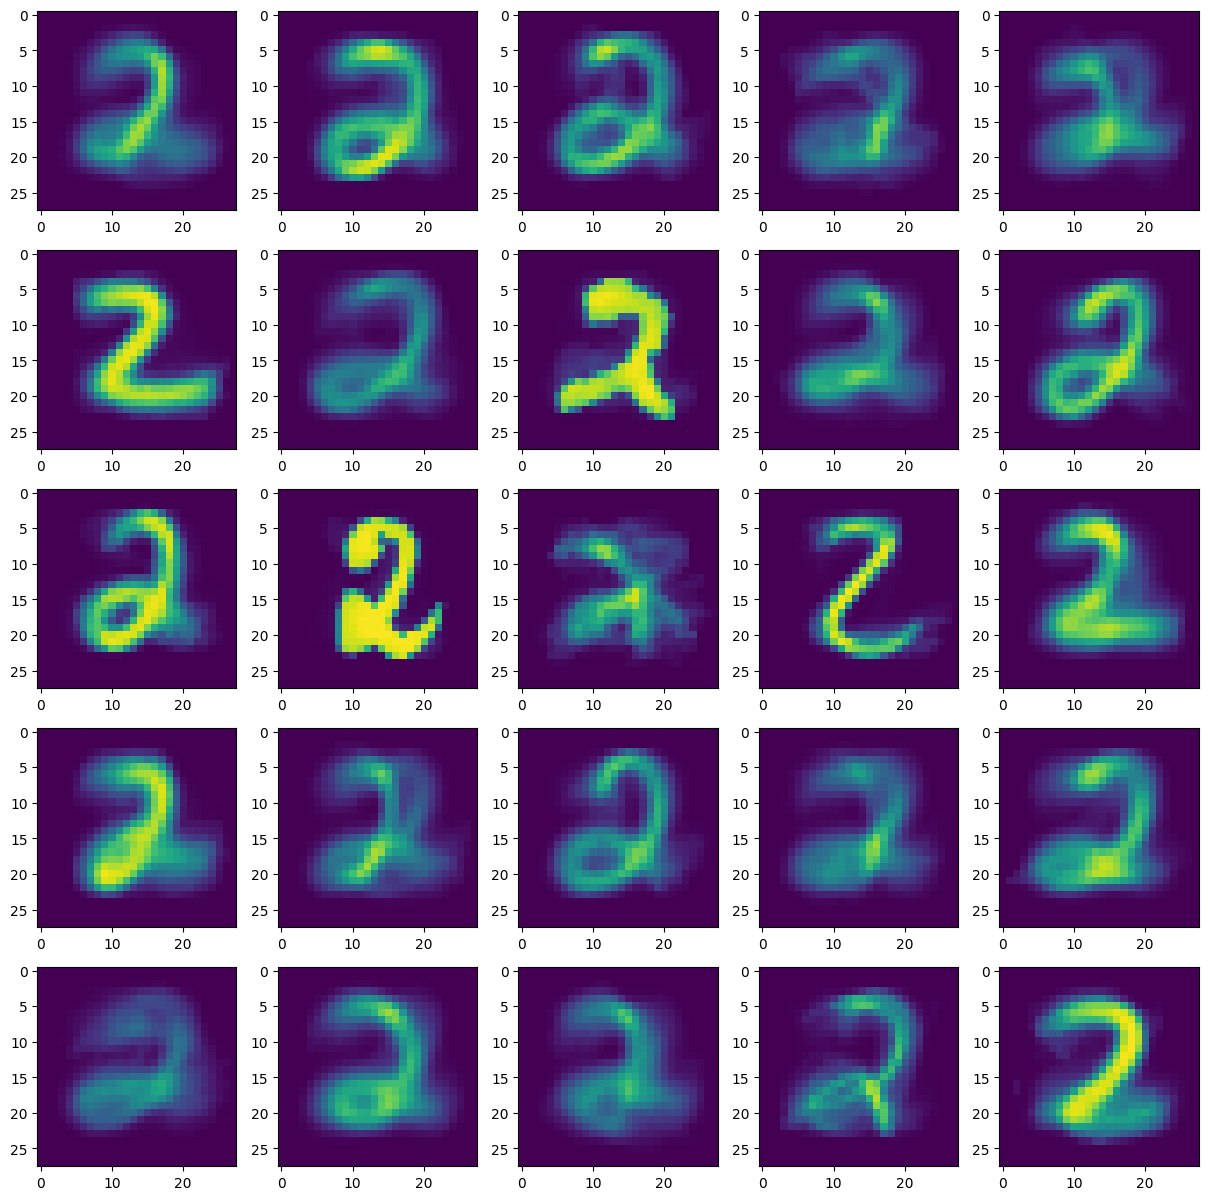

In [38]:
plot_dataset(transported_samples)

# **Conclusion**

In this tutorial, we have conducted experiments to test the computational efficiency of the entropy map, and the results are promising, as described in the article. The computation time required for the entropy map is relatively efficient, making it practical for real-world applications, as we have seen in our experiments. 
In conclusion, the entropy estimator exhibits efficient performance. Although the theoretical convergence rate may not be optimal, the estimator performs well in real-world applications, demonstrating its potential usefulness.